In [7]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import math

# Generate the path
def gen_path(length: float, dt: float) -> tuple[float, np.ndarray, np.ndarray]:
    N = 50
    r0 = np.sqrt(np.random.uniform(0.0,50.0, (N,1)))
    r1 = np.random.uniform(0.0,6.2, (N,1))
    r2 = np.random.uniform(0.0,2.0, (N,1))/(r0*r0)
    t = np.reshape(np.linspace(0, length, int(length / dt)), (1,-1))
    x = np.sum(np.sin(t * r0 + r1) * r2, axis=0)
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    t = t[0]
    return dt, t, x

# PID Controller
class PIDController:
    def __init__(self, kp=0.5, ki=0.5, kd=0.5):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.prev_x = 0.0
        self.prev_tx = 0.0
        self.integral = 0.0

    def control(self, x, tx, dt):
        self.integral += (tx - x) * dt
        self.integral *= pow(0.5, dt)
        derivative = ((tx - self.prev_tx) - (x - self.prev_x)) / dt
        output = self.kp * (tx - x) + self.ki * self.integral + self.kd * derivative
        self.prev_x = x
        self.prev_tx = tx
        return output

class TheSystem:
    def __init__(self, mass: float, mu_s: float, mu_k: float, x=0.0, v=0.0) -> None:
        self.x = x
        self.v = v
        self.mass = mass
        self.mu_s = mu_s
        self.mu_k = mu_k
    def step(self, dt: float, force: float):
        force = force_response(force, self.v, self.mass, self.mu_k) * np.random.uniform(0.95,1.05)
        friction = 0.0
        g = 10
        if abs(self.v) > 0.001:
            friction = -abs(self.v)/self.v * self.mu_k * g
        else:
            friction = np.clip(-force, -self.mu_s * g, self.mu_s * g)

        a = (force + friction) / self.mass
        self.v += a / 2 * dt
        self.x += self.v * dt
        self.v += a / 2 * dt

def force_response(power: float, vel : float, mass: float, muKinetic: float):
    GRAVITY_ACCEL = 9.8
    linearTopSpeed = 2

    maxLinearVel = (4 - math.exp(1.45 - abs(np.clip(power,-1,1)))) / 4.0 * linearTopSpeed
    friction = GRAVITY_ACCEL * mass * muKinetic
    forceMag = 100 * math.exp((maxLinearVel - abs(vel)) / linearTopSpeed * 5.0)
    return np.sign(power) * forceMag

# Update PID parameters based on action
def update_pid_by_action(pid: PIDController, action: int, dt: float):
    R = 10.0
    if action == 0: # Idle
        pass
    elif action == 1:  # Increase KP
        pid.kp += 0.1 * dt * R
    elif action == 2:  # Decrease KP
        pid.kp -= 0.1 * dt * R
    elif action == 3:  # Increase KI
        pid.ki += 0.01 * dt * R
    elif action == 4:  # Decrease KI
        pid.ki -= 0.01 * dt * R
    elif action == 5:  # Increase KD
        pid.kd += 0.1 * dt * R
    elif action == 6:  # Decrease KD
        pid.kd -= 0.1 * dt * R


qtable = np.random.uniform(0.0,1.0,[11*11*3,11])
THR = 0.05

def get_state(system: TheSystem, target: (float, float), force: float):
    tx, tv = target
    n = 0
    ex = system.x - tx
    ev = system.v - tv

    return int(np.clip(round(ex/.1), -5, 5) + 11 * np.clip(round(ev/.1), -5, 5) + 11 * 11 * np.clip(round(force/.05), -1, 1))

def get_force(action: int):
    return (action - 5) / 3.0

def get_loss(system: TheSystem, target: (float, float)):
    tx, tv = target
    return abs(system.x-tx)+abs(system.v-tv)




200 (200,)
Episode: 1, Average Loss: 44.24969550930893
200 (200,)
Episode: 2, Average Loss: 113.15511716825554
200 (200,)
Episode: 3, Average Loss: 329.62955981620166
200 (200,)
Episode: 4, Average Loss: 44.59324521863762
200 (200,)
Episode: 5, Average Loss: 63.97983836668499
200 (200,)
Episode: 6, Average Loss: 97.08550915675032
200 (200,)
Episode: 7, Average Loss: 106.93242548056891
200 (200,)
Episode: 8, Average Loss: 73.76319631403389
200 (200,)
Episode: 9, Average Loss: 383.4203061734656
200 (200,)
Episode: 10, Average Loss: 57.23048098009219
200 (200,)
Episode: 11, Average Loss: 94.30413828786428
200 (200,)
Episode: 12, Average Loss: 56.89966718689234
200 (200,)
Episode: 13, Average Loss: 43.132026202682766
200 (200,)
Episode: 14, Average Loss: 74.1996338818161
200 (200,)
Episode: 15, Average Loss: 227.83999436140925
200 (200,)
Episode: 16, Average Loss: 68.45033974371496
200 (200,)
Episode: 17, Average Loss: 141.29740555163954
200 (200,)
Episode: 18, Average Loss: 48.93676145121

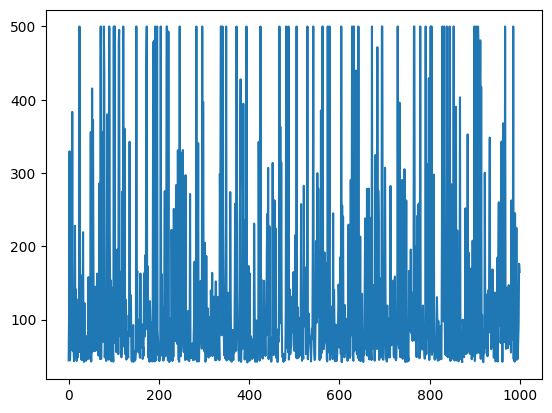

In [23]:


qtable = np.random.uniform(0.0,1.0,[11*11*3,11])

# Q-learning parameters
alpha = -0.005  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.01  # Epsilon-greedy exploration rate

# Q-learning function
def q_learning(qtable: npt.NDArray, episodes=1000):
    T = 20.0
    losses = []
    for episode in range(episodes):
        # Generate a path and reset the system
        dt, t, tx = gen_path(T, 0.1)
        print(len(t), t.shape)
        # system = TheSystem(mass=np.random.uniform(0.02,20.0))
        system = TheSystem(
            mass=np.random.uniform(0.01,50.0),
            mu_s=np.random.uniform(0.0,0.1)**2,
            mu_k=np.random.uniform(0.0,0.1)**2,
            x=tx[0], v=(tx[1]-tx[0])/dt,
        )
        pid = PIDController(np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1))
        delayed_system_x = [system.x, system.x, system.x]

        total_loss = 0
        power = 0
        scheduled_loss_updates: list[tuple[int, int, float]] = []
        for step in range(len(t)):
            target = (tx[step], (tx[step]-tx[max(step-1,0)])/dt)
            delayed_system_x.append(system.x)
            # Get the current state
            state = get_state(system, target, power)
            power = get_force(state)

            # Choose an action using epsilon-greedy policy
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, qtable.shape[1])
            else:
                action = np.argmax(qtable[state])

            # Update PID parameters based on the chosen action
            # update_pid_by_action(pid, action, dt)
            # new_kp = np.clip(pid.kp, 0.0, 200.0)
            # new_ki = np.clip(pid.ki, 0.0, 200.0)
            # new_kd = np.clip(pid.kd, 0.0, 200.0)
            # total_overshoot = abs(new_kp-pid.kp) + abs(new_ki-pid.ki) + abs(new_kd-pid.kd)
            # pid.kp = new_kp
            # pid.ki = new_ki
            # pid.kd = new_kd

            # Perform the action and get the next state
            system.step(dt, power)

            # Calculate the reward (negative of the loss)
            loss = get_loss(system, target) #+ total_overshoot * 25000
            reward = -loss

            # if loss > 100:
            #     total_loss = float("nan")
            #     for prev_state, prev_action, _ in scheduled_loss_updates:
            #         qtable[prev_state, prev_action] -= alpha * 100
            #     break

            for i in range(len(scheduled_loss_updates)):
                prev_state, prev_action, accumulated_reward = scheduled_loss_updates[i]
                # accumulated_reward *= pow(0.5,dt)
                accumulated_reward += reward
                scheduled_loss_updates[i] = (prev_state, prev_action, accumulated_reward)
            scheduled_loss_updates.append((state, action, 0.0))
            # Update Q-value using Q-learning formula
            # qtable[current_state, action] += alpha * (reward + gamma * np.max(qtable[next_state]) - qtable[current_state, action])
            if len(scheduled_loss_updates) > 0.2/dt:
                prev_state, prev_action, accumulated_reward = scheduled_loss_updates.pop(0)
                # qtable[prev_state, prev_action] += alpha * (reward + gamma * np.max(qtable[state]) - qtable[prev_state, prev_action])
                qtable[prev_state, prev_action] += alpha * accumulated_reward * dt
                qtable = (
                    qtable 
                    - np.repeat(np.reshape(np.min(qtable,axis=1),[-1,1]),11,axis=1)
                )/(
                    np.repeat(np.reshape(np.max(qtable,axis=1),[-1,1]),11,axis=1)
                    - np.repeat(np.reshape(np.min(qtable,axis=1),[-1,1]),11,axis=1)
                )

            if t[step] > T/2:
                total_loss += loss
        
        losses.append(total_loss/(len(t)/2))
        # Print average loss for each episode
        print(f"Episode: {episode + 1}, Average Loss: {total_loss / (len(t)/2)}")

    return qtable, losses


# Run Q-learning
qtable, losses = q_learning(qtable, episodes=1000)

plt.plot(np.clip(losses,0.0,500.0))

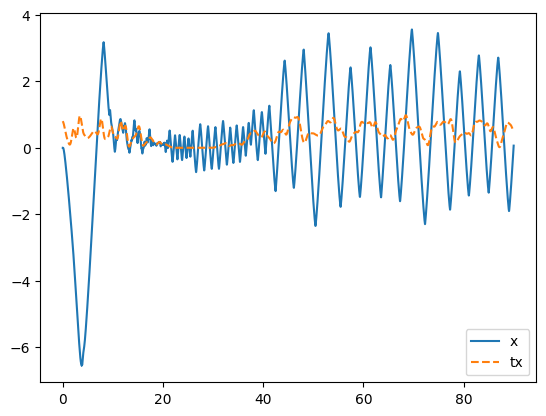

In [24]:
qta = np.argmax(qtable, axis=1)
# Q-learning function
def q_run(system: TheSystem, pid: PIDController, qtable: npt.NDArray, path: tuple[float, npt.NDArray, npt.NDArray]):
    # Generate a path and reset the system
    dt, t, x = path

    xs = []
    kps = []
    kis = []
    kds = []

    for step in range(t.shape[0]):
        target = (x[step],(x[step]-x[max(0,step-1)])/dt)
        power = pid.control(system.x, target[0], dt)
        # Get the current state

        # Update PID parameters based on the chosen action
        update_pid_by_action(pid, qta[get_state(system, target, power)], dt)
        # pid.kp = np.clip(pid.kp, 0.0, 2.0)
        # pid.ki = np.clip(pid.ki, 0.0, 2.0)
        # pid.kd = np.clip(pid.kd, 0.0, 2.0)

        # Perform the action and get the next state
        system.step(dt, 10.0*np.clip(power,-5.0,5.0))
        system.v = np.clip(system.v, -5.0,5.0)

        xs.append(system.x)

        kps.append(pid.kp)
        kis.append(pid.ki)
        kds.append(pid.kd)



    return t, np.array(xs), np.array(kps), np.array(kis), np.array(kds)


_, tt, path1, = gen_path(90.0,0.01)
_, _, path2, = gen_path(90.0,0.01)
_, _, path3, = gen_path(90.0,0.01)
t = np.linspace(0.0, 2.0, int(90.0/0.01))
path = (0.01, tt, 
        np.clip(2.0 - 4*t, 0.0,1.0) * path1
        + np.clip(3*t-2.0, 0.0,1.0) * path2
 #path1 * np.clip(2.0 - t/ 20.0,0.0,1.0))
        )

# t,x,kps,kis,kds = q_run(TheSystem(10.0,0.004,0.01),PIDController(np.random.uniform(0.1, 0.9),np.random.uniform(0.1, 0.9),np.random.uniform(0.1, 0.9)),qtable,path)
t,x,kps,kis,kds = q_run(TheSystem(10.0,0.01,0.01),PIDController(0.0,0.0,0.0),qtable,path)
plt.plot(t,x)
plt.plot(t,path[2],"--")
# plt.plot(t,kps,":")
# plt.plot(t,kis,":")
# plt.plot(t,kds,":")

plt.legend(["x","tx","kp","ki","kd"])

In [25]:
np.argmax(qtable, axis=1)

array([ 7,  3,  3, 10,  4,  5,  9,  9,  4,  4,  9,  5,  0,  6,  4,  1,  0,
        6,  8, 10,  7,  0,  7,  0,  0,  7,  6,  0,  7, 10, 10,  5,  9,  8,
        6,  4,  8,  8,  0,  2,  7,  8,  6,  5,  4,  7,  4,  6,  6,  5,  1,
        5, 10,  8,  8,  2, 10,  0,  5,  4,  6,  1,  8,  4,  7,  3,  1,  9,
        7,  6,  4,  8,  2,  7, 10,  7,  1,  3, 10,  1,  5,  9,  8,  1,  0,
        1,  3, 10,  0,  1,  9,  1,  3,  1,  1,  5,  6,  1, 10,  6,  9,  6,
        4,  2,  0,  0, 10,  6,  4, 10,  7, 10,  7, 10,  1,  1,  1,  3,  5,
        5,  9,  9,  4,  3,  4,  5,  2,  0, 10,  3,  8,  3,  6,  5,  5,  0,
        7,  8, 10,  3,  6,  9,  7,  0,  4,  8,  4,  7,  6,  7,  4,  6,  4,
       10,  7,  3,  7, 10,  3,  7,  7,  2, 10,  9,  7,  3, 10, 10,  6,  1,
        3,  1,  0,  3,  3,  1,  1,  8,  9, 10,  1,  8,  5,  4,  3,  8,  0,
        0,  5,  2,  0,  1,  2,  0,  4,  1,  4,  6,  6,  4,  6,  7,  8,  8,
        9,  1,  0,  4,  6,  2,  3,  4,  8,  8,  0,  7, 10,  5,  3,  4,  9,
        7,  0,  6,  9,  2